la dinamica della rete è descitta dall'equazione: tau*dx_i/dt=-x_i(t)+sum(J_ij*r_j(t))+sum(B_ik*u_k(t)) con r_j(t)=tanh(x_i(t))

In [74]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd

Generation class trial

In [75]:
def trial(stim1,stim2,T=1000):
        
    u=np.zeros((T,2))
    
    ty=2*stim1+stim2          #!!!! modified              #trial type: 0=AA, 1=BA, 2=AB, 3=BB

    ''' 
    if stim=0 (A) u1=1 and u2=0
    if stim=1 (B) u1=0 and u2=1
    '''
    
    u[:200,stim1]=1
    u[400:600,stim2]=1

    ''' 
    if identical inputs, output = -1
    if different inputs, output = 1
    '''
    
    #y[800:1000]=-1+2*np.mod(stim1+stim2,2)
    y=-1+2*np.mod(stim1+stim2,2)
    
    return u,y,ty


def generate_trials(n_trials,T=1000):

    U = np.zeros((n_trials,T,2))
    Y = np.zeros(n_trials)#,T))
    TY=np.zeros(n_trials)

    for n in range(n_trials):
        
        u,y,ty=trial(T)
        
        U[n,:,:]=u
        #Y[n,:]=y
        Y[n]=y
        TY[n]=ty

    return U,Y,TY
        

Constants and initialization

In [76]:
##### eta=0.1, alpha=0.5, rate=1., th=0.001


N=200           #numero neuroni
M=2             #numero input
tau=30          #tempo di rilassamento
g=1.5           #early chaotic
eta=0.1         #learning rate
alpha=0.5       #!!!! running average of response
beta = 0.05     #!!!! running average of x
rate=1./1000    #!!!
th=1E-3

dt=1.
T=1000
n_trials=4
tottime=T*n_trials

b=dt/tau            #per semplicità definisco una nuova costante


J=np.zeros((N,N))
deltaJ=np.zeros((N,N))  
x=np.zeros(N)       ##!!!
x_ave=np.zeros(N)   ##!!!
r=np.zeros(N)
u=np.zeros((M,tottime))

E=np.zeros((N,N))#,tottime)) 

z=np.zeros(tottime)
B=np.zeros((N,M))

R_ave=np.zeros(4)       #running average for each trial type
err=np.zeros(n_trials)



PRE TRAINING

In [77]:
J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)

J = np.loadtxt('Jstep0.txt')
B = np.loadtxt('B_input.txt')

Fix biased neurons

In [78]:
n_fixed=4

x[0:4]=1



NO Training (NO UPDATE)

In [79]:
np.random.seed(0)

x[:]=-0.1+0.2*np.random.rand(N) #!!!!
x[0:3]=1
E=np.zeros((N,N))#,tottime)) 
r[:]=0
R_ave=np.zeros(4)
outp=0
deltaE=np.zeros((N,N))
deltax=np.zeros(N)
rprev=np.zeros(N)

tottime=4000
XX=np.zeros((200,tottime))
U0=np.zeros(tottime)
U1=np.zeros(tottime)


for ntime in range(tottime):

    XX[:,ntime]=x[:]

    
    if(np.mod(ntime,1*T)==0):
        print(ntime)
        print(R_ave)

    trialtime=np.mod(ntime,T)
    
    curr_trial = np.floor(ntime/T).astype(int)
    
    if trialtime==0: 
        stim2=np.mod(curr_trial,2).astype(int)
        stim1=(np.mod(curr_trial,4)/2).astype(int)
        u,y,ty=trial(stim1, stim2)

    U0[ntime]=u[trialtime,0]
    U1[ntime]=u[trialtime,1]
    
    if trialtime>=800 and trialtime<1000:
        outp+=r[-1] 
                
    r=np.tanh(x)
    
    noise1=(np.random.rand(N)<rate)*(-0.5+1.*np.random.rand(N))
            
    sumJ=np.matmul(J,r)
            
    sumB=np.matmul(B,u[trialtime,:])
        
    x[4:]=x[4:]/(1+b)+b/(1+b)*(sumJ[4:]+sumB[4:])       #IMPLICITO

    x+=noise1 

    deltax=x-x_ave
    
    x_ave=beta*x_ave+(1.-beta)*x;  
   
    rprev=r
    #deltaE=np.outer(deltax,rprev) 
    #deltaE=pow(deltaE,3)
    
    #E+=deltaE

    
    if(np.mod(ntime,T)==T-1):                       #ultimo time step di ciascun trial 
        
        curr_trial=ntime//T
        curr_ty=ty #trial type : 0=AA, 1=BA, 2=AB, 3=BB
        outp=outp/200

        err[curr_trial]=abs(y-outp)           
        R=-err[curr_trial]
        
        print('type',curr_ty,err[curr_trial])
    
        #deltaJ=-eta*(R-R_ave[curr_ty])*E*(-R_ave[curr_ty]);

        ### !!!
        th=1.E-3
        deltaJ[deltaJ>th]=th
        deltaJ[deltaJ<-th]=-th

        #J+=deltaJ

        R_ave[curr_ty]=alpha*R_ave[curr_ty]+(1-alpha)*R
        
        deltaJ=np.zeros((N,N)) 
        E=np.zeros((N,N))
        x[:]=-0.1+0.2*np.random.rand(N)
        x[:4]=1
        r[:]=0
        outp=0

        

0
[0. 0. 0. 0.]
type 0 1.3690249071545249
1000
[-0.68451245  0.          0.          0.        ]
type 1 0.46135657513606665
2000
[-0.68451245 -0.23067829  0.          0.        ]
type 2 0.13295467140409
3000
[-0.68451245 -0.23067829 -0.06647734  0.        ]
type 3 1.845320489838731


AA

In [80]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX[:,:1000])
U1=np.matmul(B[:,1],XX[:,:1000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX[i,:1000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]


countsA_AA_pre, binsA_AA_pre = np.histogram(coffA,20)
countsB_AA_pre, binsB_AA_pre = np.histogram(coffB,20)
countsC_AA_pre, binsC_AA_pre = np.histogram(coffC,20)
countsD_AA_pre, binsD_AA_pre = np.histogram(coffD,20)

AApre_A=pd.DataFrame(
    {
        "BIN": binsA_AA_pre[:-1],
        "COUNTS": countsA_AA_pre,
        "COEFF": ["A"],
        "TRIAL": ["AA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20),
)
AApre_B=pd.DataFrame(
    {
        "BIN": binsB_AA_pre[:-1],
        "COUNTS": countsB_AA_pre,
        "COEFF": ["B"],
        "TRIAL": ["AA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20),
)

AApre_C=pd.DataFrame(
    {
        "BIN": binsC_AA_pre[:-1],
        "COUNTS": countsC_AA_pre,
        "COEFF": ["C"],
        "TRIAL": ["AA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20),
)

AApre_D=pd.DataFrame(
    {
        "BIN": binsD_AA_pre[:-1],
        "COUNTS": countsD_AA_pre,
        "COEFF": ["D"],
        "TRIAL": ["AA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20),
)



<Axes: xlabel='COEFF', ylabel='BIN'>

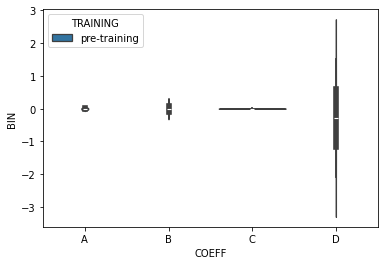

In [81]:
sns.violinplot(AApre, x='COEFF', y='BIN', hue='TRAINING')

AB

In [82]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)
U0=np.matmul(B[:,0],XX[:,1000:2000])
U1=np.matmul(B[:,1],XX[:,1000:2000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX[i,1000:2000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]

countsA_AB_pre, binsA_AB_pre = np.histogram(coffA,20)
countsB_AB_pre, binsB_AB_pre = np.histogram(coffB,20)
countsC_AB_pre, binsC_AB_pre = np.histogram(coffC,20)
countsD_AB_pre, binsD_AB_pre = np.histogram(coffD,20)

ABpre_A=pd.DataFrame(
    {
        "BIN": binsA_AB_pre[:-1],
        "COUNTS": countsA_AB_pre,
        "COEFF": ["A"],
        "TRIAL": ["AB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20,40),
)
ABpre_B=pd.DataFrame(
    {
        "BIN": binsB_AB_pre[:-1],
        "COUNTS": countsB_AB_pre,
        "COEFF": ["B"],
        "TRIAL": ["AB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20,40),
)

ABpre_C=pd.DataFrame(
    {
        "BIN": binsC_AB_pre[:-1],
        "COUNTS": countsC_AB_pre,
        "COEFF": ["C"],
        "TRIAL": ["AB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20,40),
)

ABpre_D=pd.DataFrame(
    {
        "BIN": binsD_AB_pre[:-1],
        "COUNTS": countsD_AB_pre,
        "COEFF": ["D"],
        "TRIAL": ["AB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(20,40),
)



BA

In [83]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX[:,2000:3000])
U1=np.matmul(B[:,1],XX[:,2000:3000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX[i,2000:3000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]

countsA_BA_pre, binsA_BA_pre = np.histogram(coffA,20)
countsB_BA_pre, binsB_BA_pre = np.histogram(coffB,20)
countsC_BA_pre, binsC_BA_pre = np.histogram(coffC,20)
countsD_BA_pre, binsD_BA_pre = np.histogram(coffD,20)


BApre_A=pd.DataFrame(
    {
        "BIN": binsA_BA_pre[:-1],
        "COUNTS": countsA_BA_pre,
        "COEFF": ["A"],
        "TRIAL": ["BA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(40,60),
)
BApre_B=pd.DataFrame(
    {
        "BIN": binsB_BA_pre[:-1],
        "COUNTS": countsB_BA_pre,
        "COEFF": ["B"],
        "TRIAL": ["BA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(40,60),
)

BApre_C=pd.DataFrame(
    {
        "BIN": binsC_BA_pre[:-1],
        "COUNTS": countsC_BA_pre,
        "COEFF": ["C"],
        "TRIAL": ["BA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(40,60),
)

BApre_D=pd.DataFrame(
    {
        "BIN": binsD_BA_pre[:-1],
        "COUNTS": countsD_BA_pre,
        "COEFF": ["D"],
        "TRIAL": ["BA"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(40,60),
)


BB

In [84]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX[:,3000:4000])
U1=np.matmul(B[:,1],XX[:,3000:4000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX[i,3000:4000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]

countsA_BB_pre, binsA_BB_pre = np.histogram(coffA,20)
countsB_BB_pre, binsB_BB_pre = np.histogram(coffB,20)
countsC_BB_pre, binsC_BB_pre = np.histogram(coffC,20)
countsD_BB_pre, binsD_BB_pre = np.histogram(coffD,20)

BBpre_A=pd.DataFrame(
    {
        "BIN": binsA_BB_pre[:-1],
        "COUNTS": countsA_BB_pre,
        "COEFF": ["A"],
        "TRIAL": ["BB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(60,80),
)
BBpre_B=pd.DataFrame(
    {
        "BIN": binsB_BB_pre[:-1],
        "COUNTS": countsB_BB_pre,
        "COEFF": ["B"],
        "TRIAL": ["BB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(60,80),
)

BBpre_C=pd.DataFrame(
    {
        "BIN": binsC_BB_pre[:-1],
        "COUNTS": countsC_BB_pre,
        "COEFF": ["C"],
        "TRIAL": ["BB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(60,80),
)

BBpre_D=pd.DataFrame(
    {
        "BIN": binsD_BB_pre[:-1],
        "COUNTS": countsD_BB_pre,
        "COEFF": ["D"],
        "TRIAL": ["BB"],
        "TRAINING": ["pre-training"]
    },
    index=np.arange(60,80),
)



------- POST TRAINING -------

In [85]:
J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)

J = np.loadtxt('Jstep20.txt')
B = np.loadtxt('B_input.txt')

Fix biased neurons

In [86]:
n_fixed=4

x[0:4]=1



In [87]:
np.random.seed(0)

x[:]=-0.1+0.2*np.random.rand(N) #!!!!
x[0:3]=1
E=np.zeros((N,N))#,tottime)) 
r[:]=0
R_ave=np.zeros(4)
outp=0
deltaE=np.zeros((N,N))
deltax=np.zeros(N)
rprev=np.zeros(N)

tottime=4000
XX_f=np.zeros((200,tottime))
U0=np.zeros(tottime)
U1=np.zeros(tottime)



for ntime in range(tottime):

    XX_f[:,ntime]=x[:]

    
    if(np.mod(ntime,1*T)==0):
        print(ntime)
        print(R_ave)

    trialtime=np.mod(ntime,T)
    
    curr_trial = np.floor(ntime/T).astype(int)
    
    if trialtime==0: 
        stim2=np.mod(curr_trial,2).astype(int)
        stim1=(np.mod(curr_trial,4)/2).astype(int)
        u,y,ty=trial(stim1, stim2)
    
    U0[ntime]=u[trialtime,0]
    U1[ntime]=u[trialtime,1]

    
    if trialtime>=800 and trialtime<1000:
        outp+=r[-1] 
                
    r=np.tanh(x)
    
    noise1=(np.random.rand(N)<rate)*(-0.5+1.*np.random.rand(N))
            
    sumJ=np.matmul(J,r)
            
    sumB=np.matmul(B,u[trialtime,:])
        
    x[4:]=x[4:]/(1+b)+b/(1+b)*(sumJ[4:]+sumB[4:])       #IMPLICITO

    x+=noise1 

    deltax=x-x_ave
    
    x_ave=beta*x_ave+(1.-beta)*x;  
   
    rprev=r
    deltaE=np.outer(deltax,rprev) 
    deltaE=pow(deltaE,3)
    
    E+=deltaE

    
    if(np.mod(ntime,T)==T-1):                       #ultimo time step di ciascun trial 
        
        curr_trial=ntime//T
        curr_ty=ty #trial type : 0=AA, 1=BA, 2=AB, 3=BB
        outp=outp/200

        err[curr_trial]=abs(y-outp)           
        R=-err[curr_trial]
        
        print('type',curr_ty,err[curr_trial])
    
        deltaJ=-eta*(R-R_ave[curr_ty])*E*(-R_ave[curr_ty]);

        ### !!!
        th=1.E-3
        deltaJ[deltaJ>th]=th
        deltaJ[deltaJ<-th]=-th

        #J+=deltaJ

        R_ave[curr_ty]=alpha*R_ave[curr_ty]+(1-alpha)*R
        
        deltaJ=np.zeros((N,N)) 
        E=np.zeros((N,N))
        x[:]=-0.1+0.2*np.random.rand(N)
        x[:4]=1
        r[:]=0
        outp=0

        

0
[0. 0. 0. 0.]
type 0 0.1820909499790414
1000
[-0.09104547  0.          0.          0.        ]
type 1 0.05315156048387859
2000
[-0.09104547 -0.02657578  0.          0.        ]
type 2 0.09428598234128938
3000
[-0.09104547 -0.02657578 -0.04714299  0.        ]
type 3 0.04716046433521304


AA

In [88]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX_f[:,:1000])
U1=np.matmul(B[:,1],XX_f[:,:1000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]
for i in range(200):
    y=XX_f[i,:1000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_

countsA_AA_post, binsA_AA_post = np.histogram(coffA,20)
countsB_AA_post, binsB_AA_post = np.histogram(coffB,20)
countsC_AA_post, binsC_AA_post = np.histogram(coffC,20)
countsD_AA_post, binsD_AA_post = np.histogram(coffD,20)

AApost_A=pd.DataFrame(
    {
        "BIN": binsA_AA_post[:-1],
        "COUNTS": countsA_AA_post,
        "COEFF": ["A"],
        "TRIAL": ["AA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(80,100),
)
AApost_B=pd.DataFrame(
    {
        "BIN": binsB_AA_post[:-1],
        "COUNTS": countsB_AA_post,
        "COEFF": ["B"],
        "TRIAL": ["AA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(80,100),
)

AApost_C=pd.DataFrame(
    {
        "BIN": binsC_AA_post[:-1],
        "COUNTS": countsC_AA_post,
        "COEFF": ["C"],
        "TRIAL": ["AA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(80,100),
)

AApost_D=pd.DataFrame(
    {
        "BIN": binsD_AA_post[:-1],
        "COUNTS": countsD_AA_post,
        "COEFF": ["D"],
        "TRIAL": ["AA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(80,100),
)



AB

In [89]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX_f[:,1000:2000])
U1=np.matmul(B[:,1],XX_f[:,1000:2000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX_f[i,1000:2000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]

countsA_AB_post, binsA_AB_post = np.histogram(coffA,20)
countsB_AB_post, binsB_AB_post = np.histogram(coffB,20)
countsC_AB_post, binsC_AB_post = np.histogram(coffC,20)
countsD_AB_post, binsD_AB_post = np.histogram(coffD,20)

ABpost_A=pd.DataFrame(
    {
        "BIN": binsA_AB_post[:-1],
        "COUNTS": countsA_AB_post,
        "COEFF": ["A"],
        "TRIAL": ["AB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(100,120),
)
ABpost_B=pd.DataFrame(
    {
        "BIN": binsB_AB_post[:-1],
        "COUNTS": countsB_AB_post,
        "COEFF": ["B"],
        "TRIAL": ["AB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(100,120),
)

ABpost_C=pd.DataFrame(
    {
        "BIN": binsC_AB_post[:-1],
        "COUNTS": countsC_AB_post,
        "COEFF": ["C"],
        "TRIAL": ["AB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(100,120),
)

ABpost_D=pd.DataFrame(
    {
        "BIN": binsD_AB_post[:-1],
        "COUNTS": countsD_AB_post,
        "COEFF": ["D"],
        "TRIAL": ["AB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(100,120),
)



BA

In [90]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX_f[:,2000:3000])
U1=np.matmul(B[:,1],XX_f[:,2000:3000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX_f[i,2000:3000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]


countsA_BA_post, binsA_BA_post = np.histogram(coffA,20)
countsB_BA_post, binsB_BA_post = np.histogram(coffB,20)
countsC_BA_post, binsC_BA_post = np.histogram(coffC,20)
countsD_BA_post, binsD_BA_post = np.histogram(coffD,20)

BApost_A=pd.DataFrame(
    {
        "BIN": binsA_BA_post[:-1],
        "COUNTS": countsA_BA_post,
        "COEFF": ["A"],
        "TRIAL": ["BA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(120,140),
)
BApost_B=pd.DataFrame(
    {
        "BIN": binsB_BA_post[:-1],
        "COUNTS": countsB_BA_post,
        "COEFF": ["B"],
        "TRIAL": ["BA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(120,140),
)

BApost_C=pd.DataFrame(
    {
        "BIN": binsC_BA_post[:-1],
        "COUNTS": countsC_BA_post,
        "COEFF": ["C"],
        "TRIAL": ["BA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(120,140),
)

BApost_D=pd.DataFrame(
    {
        "BIN": binsD_BA_post[:-1],
        "COUNTS": countsD_BA_post,
        "COEFF": ["D"],
        "TRIAL": ["BA"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(120,140),
)



BB

In [91]:
coffA=np.zeros(200)
coffB=np.zeros(200)
coffC=np.zeros(200)
coffD=np.zeros(200)

U0=np.matmul(B[:,0],XX_f[:,3000:4000])
U1=np.matmul(B[:,1],XX_f[:,3000:4000])
U2=U0*U1

X=[U0, U1, U2]
X=np.transpose(X)

for i in range(200):
    y=XX_f[i,3000:4000]
    regr = LinearRegression()
    regr.fit(X, y)
    coffA[i]=regr.coef_[0]
    coffB[i]=regr.coef_[1]
    coffC[i]=regr.coef_[2]
    coffD[i]=regr.intercept_
#XX[i,t]=A[i]*UU[t,0]+B[i]*UU[t,1]+C[i]*UU[t,0]*UU[t,1]+D[i]

countsA_BB_post, binsA_BB_post = np.histogram(coffA,20)
countsB_BB_post, binsB_BB_post = np.histogram(coffB,20)
countsC_BB_post, binsC_BB_post = np.histogram(coffC,20)
countsD_BB_post, binsD_BB_post = np.histogram(coffD,20)

BBpost_A=pd.DataFrame(
    {
        "BIN": binsA_BB_post[:-1],
        "COUNTS": countsA_BB_post,
        "COEFF": ["A"],
        "TRIAL": ["BB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(140,160),
)
BBpost_B=pd.DataFrame(
    {
        "BIN": binsB_BB_post[:-1],
        "COUNTS": countsB_BB_post,
        "COEFF": ["B"],
        "TRIAL": ["BB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(140,160),
)

BBpost_C=pd.DataFrame(
    {
        "BIN": binsC_BB_post[:-1],
        "COUNTS": countsC_BB_post,
        "COEFF": ["C"],
        "TRIAL": ["BB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(140,160),
)

BBpost_D=pd.DataFrame(
    {
        "BIN": binsD_BB_post[:-1],
        "COUNTS": countsD_BB_post,
        "COEFF": ["D"],
        "TRIAL": ["BB"],
        "TRAINING": ["post-training"]
    },
    index=np.arange(140,160),
)



In [93]:
frames1 = [AApre_A, ABpre_A, BApre_A, BBpre_A, AApost_A, ABpost_A, BApost_A, BBpost_A]
ATOT=pd.concat(frames1)

frames2 = [AApre_B, ABpre_B, BApre_B, BBpre_B, AApost_B, ABpost_B, BApost_B, BBpost_B]
BTOT=pd.concat(frames2)

frames3 = [AApre_C, ABpre_C, BApre_C, BBpre_C, AApost_C, ABpost_C, BApost_C, BBpost_C]
CTOT=pd.concat(frames3)

frames4 = [AApre_D, ABpre_D, BApre_D, BBpre_D, AApost_D, ABpost_D, BApost_D, BBpost_D]
DTOT=pd.concat(frames4)


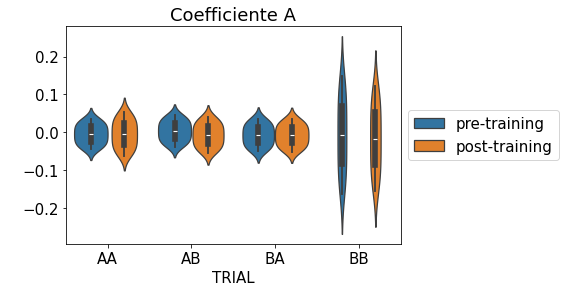

In [113]:
plt.rcParams.update({'font.size': 15})

APLOT=sns.violinplot(ATOT, x='TRIAL', y='BIN', hue='TRAINING')

APLOT.set_title('Coefficiente A')

APLOT.set_ylabel(' ', labelpad=0)

APLOT.legend(loc='center left', bbox_to_anchor=(1, 0.5))

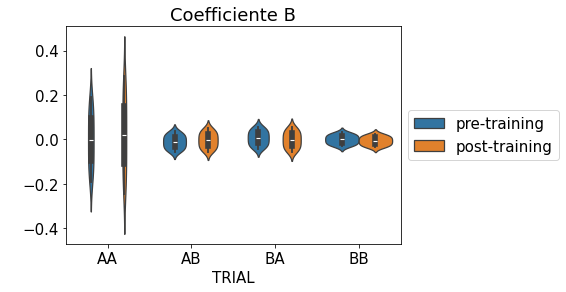

In [114]:
BPLOT=sns.violinplot(BTOT, x='TRIAL', y='BIN', hue='TRAINING')

BPLOT.set_title('Coefficiente B')

BPLOT.set_ylabel(' ', labelpad=0)

BPLOT.legend(loc='center left', bbox_to_anchor=(1, 0.5))

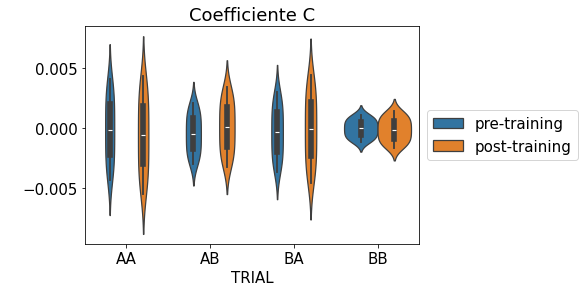

In [112]:
CPLOT=sns.violinplot(CTOT, x='TRIAL', y='BIN', hue='TRAINING')

CPLOT.set_title('Coefficiente C')

CPLOT.set_ylabel(' ', labelpad=0)

CPLOT.legend(loc='center left', bbox_to_anchor=(1, 0.5))

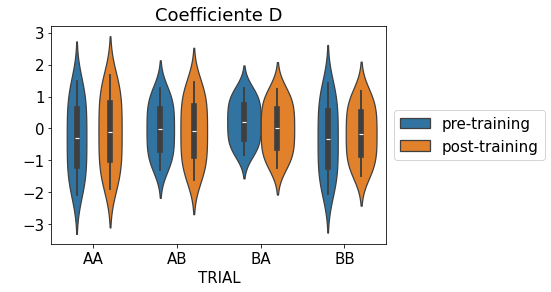

In [111]:
DPLOT=sns.violinplot(DTOT, x='TRIAL', y='BIN', hue='TRAINING')

DPLOT.set_title('Coefficiente D')

DPLOT.set_ylabel(' ', labelpad=0)

DPLOT.legend(loc='center left', bbox_to_anchor=(1, 0.5))